<a href="https://colab.research.google.com/github/mjvakili/MLcourse/blob/master/day1/k_nearest_neighbors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt

Let's generate some generic dataset with 2 classes, and a test point denoted 
by 
$\star$ sitting somewhere between the three classes of points

---



In [0]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler 

X, y_true = make_blobs(n_samples = 2000, centers = 4,
                       cluster_std = [1.5, 1, 1, 1], random_state = 0)
scaler = StandardScaler()    
scaler.fit(X)
X = scaler.transform(X)
y_true[y_true == 3] = 1
y_true[y_true == 2] = 0
#Now let's generate some test point
np.random.seed(123) # Let's make sure the results are reproducible
point = np.mean(X, axis = 0) + 1.5* np.random.rand(2) #test point

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f25475c97b8>)

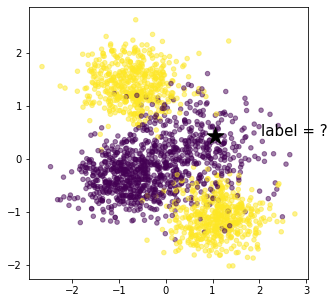

In [0]:
def plot_scatter():
    fig = plt.figure(figsize = (5,5))
    ax=fig.add_subplot(1,1,1)
    ax.scatter(X[:, 0], X[:, 1], c= y_true, alpha = 0.5, s = 20)
    ax.scatter(point[0], point[1], marker = "*", s = 300, color = "k")
    ax.text(point[0]+1, point[1], "label = ?", fontsize = 15)

    return fig, ax

plot_scatter()    

#Which class does the point $\star$ belong to? 

Let's solve this problem with a $k$-nearest neighbor classification approach:
  

There are three classes in this problem: 

(1) C1: Purple, (2) C2: Yellow.

In order to find the best macthing class ($\textit{label}$), the $\mathbf{k}$-NN algorithm draws a sphere centered on $\star$ such that the sphere contains $k$ nearest neighbors of $\star$. Then, the test point $\star$ is classified according to the class that has the majority of the members inside the sphere. 

$p(C_1|\star) = \frac{K_1}{K}$, $p(C_2|\star) = \frac{K_2}{K}$, where $K_1 + K_2= K$. 

The class with the largest $K_i$ value is assigned to $\star$.

In [0]:
from sklearn.metrics import pairwise_distances
def kNN_sphere(k):
    '''
    returns the radius of a sphere containing the 
    k neigherst neighbors of a test point
    '''
    return np.sort(pairwise_distances(point[None,:], X))[0][k-1]

In [0]:
def draw_sphere(k_list):
    
    fig, ax = plot_scatter()
    for k in k_list:
        rad = kNN_sphere(k)
        
        circle = plt.Circle(point, radius=rad, Fill = False, lw = 2, label = "k="+str(k), color = "C"+str(k))
        ax.add_patch(circle)
        plt.legend()
    
    return None    

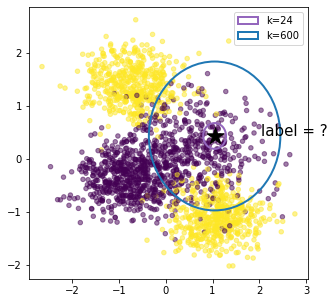

In [0]:
draw_sphere([24, 600])

As evident in this figure, when the parameter $k$ is set to 24, the majority of the points inside the sphere blong to $C_1$ (shown by purple), resulting in a high probability of the test point belonging to $C_1$. 
On the other hand, when $k$ is set to a large number (150), this probability decreases significantly.

Now let us dive deeper into how one needs to pick the optimal number of nearest neighbors for this problem.

Let's use ```train_test_split ``` from `scikit-learn` to split the generated data into a training and a test set.

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y_true)

The training set is used to fit the model and the test set is used to evaluate the performance of the model.

In [0]:
from sklearn.neighbors import KNeighborsClassifier

Note that in the case of a regression task (i.e. when `y` is a continuous variable), one can make use of the `KNeighborsRegressor`.

In [0]:
model = KNeighborsClassifier(n_neighbors=6)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("training accuracy: {:.3f}".format(model.score(X_train, y_train)))
print("test accuracy: {:.3f}".format(model.score(X_test, y_test)))

training accuracy: 0.937
test accuracy: 0.940


In [0]:
model.n_neighbors

6

A kNN model with `n_neighbors = 1` is a complex model that is able to perfectly memorize the training sample. Let's visialize the performance of the model a bit:

In [0]:
#Let's define a function that shows the decision boundaries as inferred from a KNN classifier:

def decision_boundary(X_train, y_train, grid_size, model):

    x_min, x_max = X_train[:,0].min() - 1, X_train[:,0].max()
    y_min, y_max = X_train[:,1].min() - 1, X_train[:,1].max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_size), np.arange(y_min, y_max, grid_size))
    pred = model.predict(np.c_[xx.ravel(), yy.ravel()])
    pred = pred.reshape(xx.shape)
    fig = plt.figure(figsize = (5,5))
    ax=fig.add_subplot(1,1,1)
    ax.pcolormesh(xx, yy, pred, alpha = .4)
    ax.scatter(X_test[:, 0], X_test[:, 1], c = y_test, alpha = 0.5, s = 40, edgecolor="k")
    test_acc = model.score(X_test, y_test)
    plt.title("kNN with "+str(model.n_neighbors)+" neighbors"+", test accuracy="+str(test_acc))
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

    return None

def knn_model(X_train, y_train, n_neighbor):

    model = KNeighborsClassifier(n_neighbors=n_neighbor)
    model.fit(X_train, y_train)

    return model   

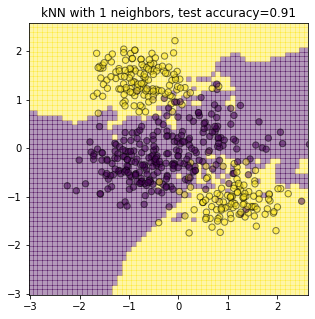

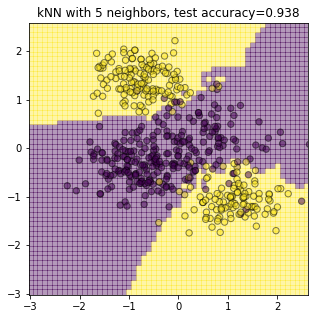

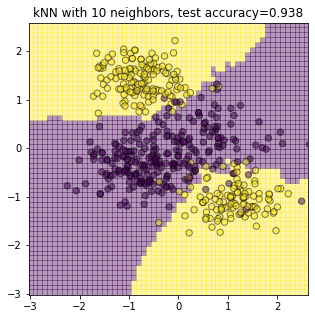

In [0]:
for n_neighbor in [1, 5, 10]:

    knn = knn_model(X_train, y_train, n_neighbor = n_neighbor)
    decision_boundary(X_train, y_train, grid_size=0.1, model=knn)

#How do we set the number of nearest neighbors? 
The number of nearest neighbors is referred to as the hyper-parameter of the model. As discussed before, a separate test set is needed to evaluate the performance of the model. So the model tuning should not be performed on the test set, otherwise the test set will be very optimistic. 

We discuss two way of splitting the data for the purpose hyperparameter tuning and model evaluations:

(1) Three-fold split: train/validation/test split: 

In the 3-fold split, the training set is used for model fitting, the validation set is used for parameter selection, and the test set is used for model performance evaluation. The validation set is sometimes called the development set in that it is used for the model development.

The training set is used for training the algorithms; the validation set is used for finding out which one of the different models performs best.
Once we have a model that we trust, we exmine its performance on the test set. The model evaluation on the test set, will provide an unbiased way of estimating how well the model performs. 

The choice of ratios for dividing the data into train/validation/test depends on the size of the data; For a moderately-size dataset, an often choice of split is 60$\%$/20$\%$/20$\%$, but in th big data regime where one might have a dataset with a size of $10^6$ one could dedicate a much higher percentage to the training set ($\sim 98\%$) and then $~1\%$ for the validation and $~1\%$ for the test set.

(2) Cross validation:



In [0]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y_true, train_size = 0.8) # 80% train/val & 20% test
X_train, X_val, y_train, y_val= train_test_split(X_trainval, y_trainval, train_size = 0.75) # 60% train & 20% val 

test_score = 0.9


Text(0, 0.5, 'accuracy')

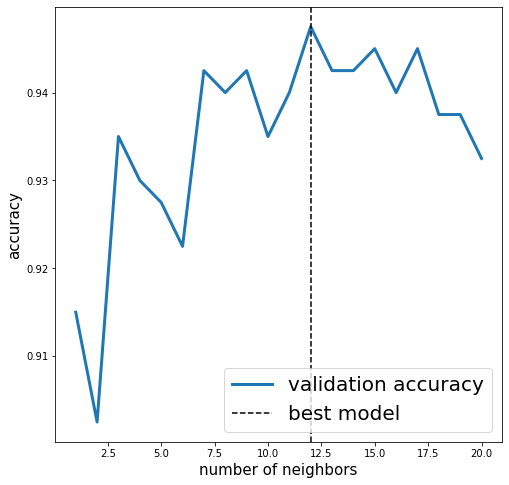

In [0]:
validation_score = []
k_list = 1 + np.arange(20)

for k in k_list:

  model = KNeighborsClassifier(n_neighbors = k)
  model.fit(X_train, y_train)
  validation_score.append(model.score(X_val, y_val))

k_best = k_list[np.argmax(validation_score)]
model_best = KNeighborsClassifier(n_neighbors = k_best)
model_best.fit(X_train, y_train)
test_score = model_best.score(X_test, y_test)
print("test_score =" , test_score)
plt.figure(figsize = (8,8))
plt.plot(k_list, validation_score, label = "validation accuracy", linewidth = 3)
plt.axvline(k_best, color = "k", linestyle = "dashed", label = "best model")
plt.legend(fontsize = 20)
plt.xlabel("number of neighbors", fontsize = 15)
plt.ylabel("accuracy", fontsize = 15)

#Cross-validation

In a $k$-fold cross validation setup, first we split the data into train/val and test set. The train/val set is divided into $k$ equal subsets. 

Then we carry out the following step $k$ times. 

At each step, we drop one of the $k$ subsets, train the model with the remaining $k-1$ subsets, and evaluate the validation score on the dopped subset. 

We continue this step $k$ times until all the $k$ subsets have been heldout once for the purpose of evaluating the validation score. 

This results in a list of $k$ scores, which we call the list of cross-validation scores. Having these $k$ scores at hand, we can calculate their mean and variance. The mean cross-validation score should be robust against the fluctuations in the scores obtained from the individual subsets. 

best value of the hyperparameter k =  18


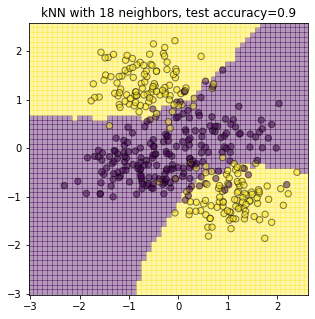

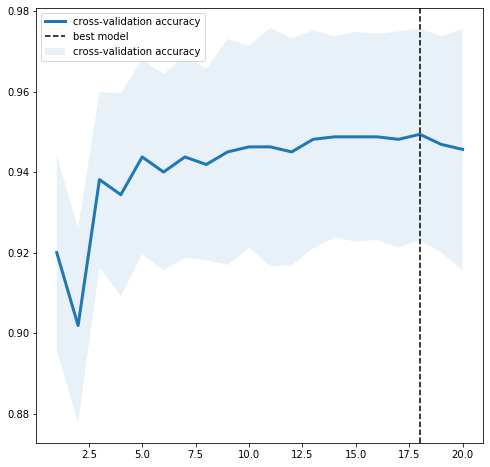

In [0]:
from sklearn.model_selection import cross_val_score

cv_scores_mean = []
cv_scores_std = []

for k in k_list:
    model = KNeighborsClassifier(n_neighbors = k)
    cv_scores = cross_val_score(model, X_trainval, y_trainval, cv = 10)
    cv_scores_mean.append(np.mean(cv_scores))
    cv_scores_std.append(np.std(cv_scores))

cv_mean, cv_std = np.array(cv_scores_mean), np.array(cv_scores_std)

k_best = k_list[np.argmax(cv_scores_mean)]

print("best value of the hyperparameter k = ", k_best)
best_model = KNeighborsClassifier(n_neighbors = k_best)
best_model.fit(X_trainval, y_trainval)
decision_boundary(X_trainval, y_trainval, grid_size = 0.1, model = best_model)

plt.figure(figsize = (8,8))
plt.plot(k_list, cv_scores_mean, label = "cross-validation accuracy", linewidth = 3)
plt.fill_between(k_list, cv_mean - cv_std ,  cv_mean + cv_std, label = "cross-validation accuracy", alpha = 0.1)
plt.axvline(k_best, color = "k", linestyle = "dashed", label = "best model")
plt.legend()

#Scaling the data

In most machine learning applications it is important to scale the different features of the data before fitting the model. That is, different features may have different spreads. Scaling the features such that they all have the same variation range makes it easier for machine learning algorithms to learn from the data. 

Scaling can be performed such that all the features of the data vary between 0 and 1, or such that all the features have a zero mean and a variance of unity. 

In `sklearn` for instance, the `MinMaxScalar` scales the data such that features of the data vary only between 0 and 1. The `StandardScalar` scales the data such that the features have zero mean and a variance of unity. 

In [0]:
X, y_true = make_blobs(n_samples = 2000, centers = 4,
                       cluster_std = [1.5, 1, 1, 1], random_state = 0)
scaler = StandardScaler()    
scaler.fit(X)
X_transformed = scaler.transform(X)
y_true[y_true == 3] = 1
y_true[y_true == 2] = 0

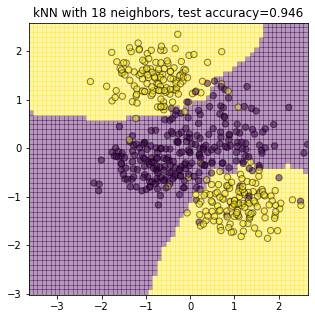

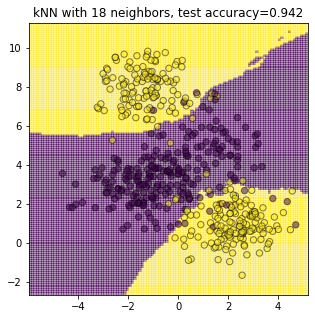

In [0]:
model_with_scaled_X = KNeighborsClassifier(n_neighbors = 18)
model_with_scaled_X.fit(X_transformed, y_true)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_true)
decision_boundary(X_transformed, y_true, grid_size = 0.1, model = model_with_scaled_X)

model_with_scaled_X = KNeighborsClassifier(n_neighbors = 18)
model_with_scaled_X.fit(X, y_true)
X_train, X_test, y_train, y_test = train_test_split(X, y_true)
decision_boundary(X, y_true, grid_size = 0.1, model = model_with_scaled_X)

As shown in these figures, the decision boundaries obtained from the kNN model fitted to the transformed and the untransformed data are different. 